In [4]:
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 678.6/678.6 kB 18.1 MB/s eta 0:00:0000:01


In [5]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)


In [6]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


473402300/473402300 [==============================] - 14s 0us/step


In [210]:
trim = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))

samples, fid  = trim.sample(2048, return_index=True)
normals = trim.face_normals[fid]
print(samples[0],normals[0])

[-3.7940085  -1.43112137  0.697012  ] [0. 0. 1.]


In [9]:
print(samples.shape)
print(normals.shape)

(100, 3)
(100, 3)


In [211]:

class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(samples, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud


In [212]:

norm_pointcloud = Normalize()(samples)

In [214]:
import random
import math
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [244]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

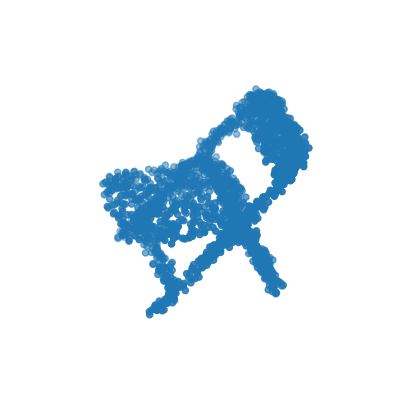

In [245]:

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(noisy_rot_pointcloud[:, 0],noisy_rot_pointcloud[:, 1], noisy_rot_pointcloud[:, 2])
ax.set_axis_off()
plt.show()

In [246]:
poincloud = np.concatenate((noisy_rot_pointcloud, normals), axis = 1)
print(pointcloud)

[[ 6.71006085e+00 -1.16619867e+00  6.97012000e-01  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [-6.20710960e+00  1.03126920e+01  1.60786327e+01 -1.02732193e-01
   8.75935932e-01 -4.71362216e-01]
 [ 9.14600306e+00  1.07705123e+01  1.65632231e+01 -6.06331075e-03
   8.71012553e-01 -4.91223339e-01]
 [ 1.69594224e+00 -8.51667919e+00  6.97012000e-01  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [-3.47412804e-01  1.05043766e+01  1.58621518e+01  2.05162764e-02
   8.72117524e-01 -4.88866144e-01]
 [ 3.64543565e+00 -6.52418378e+00  6.97012000e-01  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [-9.12975384e+00  3.20571743e-01 -1.87091702e+00  9.99948731e-01
  -8.83856525e-03  4.94114584e-03]
 [-1.35729273e+00  8.75308331e+00  1.26905429e+01  2.05455832e-02
   8.72415839e-01 -4.88332348e-01]
 [ 3.07129773e+00  4.40901437e-02  6.97012000e-01  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 9.79392310e+00  4.75036649e+00 -4.68541103e+00 -0.00000000e+00
  -9.68149463e-01 -2.5037

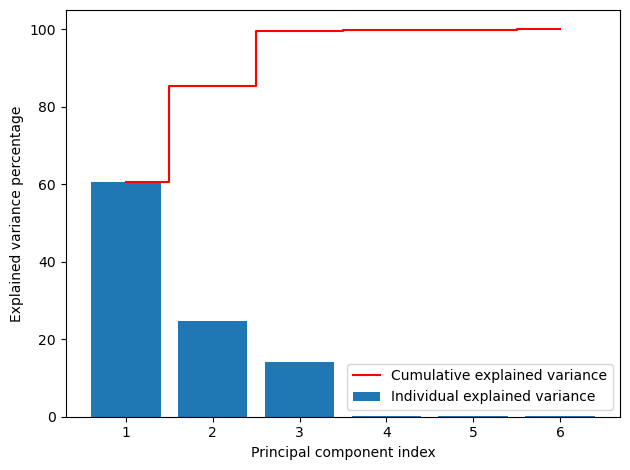

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca.fit(pointcloud)

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, 7), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 7), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=[1, 2, 3,4,5,6])
plt.legend(loc='best')
plt.tight_layout()

plt.savefig("Barplot.png")

In [249]:

pca = PCA(n_components=3)
pca.fit(pointcloud)
transformed_points = pca.transform(pointcloud)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2])
ax.set_xlabel('Composante principale 1')
ax.set_ylabel('Composante principale 2')
ax.set_zlabel('Composante principale 3')
ax.set_title('Projection des données sur les trois premières composantes principales')
plt.show()

In [7]:
import os
root=os.path.join(DATA_DIR)
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
print(dirlist)

['monitor', 'bathtub', 'table', 'dresser', 'night_stand', 'sofa', 'bed', 'toilet', 'chair', 'desk']


In [ ]:
import shutil
import os
from pathlib import Path

list_dir = ['train', 'test']
  
# enumerate on list_dir to get the 
# content of all the folders ans store it in a dictionary
content_list = {}
for classe_name in dirlist:
    current_folder=os.path.join(DATA_DIR,classe_name)
    for index, val in enumerate(list_dir):
        path = os.path.join(current_folder, val)
        content_list[ list_dir[index] ] = os.listdir(path)
        for sub_dir in content_list:

    # loop through the contents of the
    # list of folders
            for contents in content_list[sub_dir]:

                # make the path of the content to move 
                path_to_content = sub_dir + "/" + contents  

                # make the path with the current folder
                dir_to_move = os.path.join(current_folder, path_to_content)

                # move the file
                if os.path.isfile(current_folder+'/'+contents):
                    os.remove(current_folder+'/'+contents)
                    
                    if  os.path.isfile(dir_to_move):
                        shutil.move(dir_to_move,current_folder)
                else:
                    if  os.path.isfile(dir_to_move):
                        shutil.move(dir_to_move,current_folder)
    shutil.rmtree(os.path.join(current_folder,'train')) 
    shutil.rmtree(os.path.join(current_folder,'test')) 

In [63]:
for sub_dir in content_list:
  
    # loop through the contents of the
    # list of folders
    for contents in content_list[sub_dir]:
  
        # make the path of the content to move 
        path_to_content = sub_dir + "/" + contents  
  
        # make the path with the current folder
        dir_to_move = os.path.join(current_folder, path_to_content )
  
        # move the file
        shutil.move(dir_to_move,current_folder)
    shutil.rmtree(os.path.join(current_folder,sub_dir)) 
        

In [105]:
!pip install split-folders
root=os.path.join(DATA_DIR)

import splitfolders

 # or import splitfolders
input_folder =  os.path.join(DATA_DIR)
output = os.path.join(DATA_DIR) #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .2,.1))

Copying files: 908 files [00:01, 811.29 files/s] 


In [24]:
folders = os.path.join(DATA_DIR)
print(folders)

/root/.keras/datasets/ModelNet10


In [41]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    valid_points=[]
    valid_labels = []
    class_map = {}
    train_folders = glob.glob(os.path.join(DATA_DIR, "train"))
    test_folders = glob.glob(os.path.join(DATA_DIR, "test"))
    val_folders = glob.glob(os.path.join(DATA_DIR, "val"))

    for i, folder in enumerate(train_folders):
       
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "/*"))
        
        for f in train_files:
            trim=trimesh.load(f)
            
            samples, fid  = trim.sample(2048, return_index=True)
            norm_pointcloud = Normalize()(samples)
            rot_pointcloud = RandRotation_z()(norm_pointcloud)
            samples = RandomNoise()(rot_pointcloud)

            normals = trim.face_normals[fid]
            finalpoints = np.concatenate((samples, normals), axis = 1)
            pca = PCA(n_components=3)
            pca.fit(finalpoints)
            transformed_points = pca.transform(finalpoints)
            train_points.append(transformed_points)
            train_labels.append(i)
       
    for i, folder in enumerate(test_folders):
       
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        
        test_files = glob.glob(os.path.join(folder, "test/*"))
        for f in test_files:
            trim1=trimesh.load(f)
            
            
            samples1, fid1  = trim.sample(2048, return_index=True)
            norm_pointcloud = Normalize()(samples1)
            rot_pointcloud = RandRotation_z()(norm_pointcloud)
            samples1 = RandomNoise()(rot_pointcloud)
    # compute the barycentric coordinates of each sample
            normals1 = trim.face_normals[fid1]
            finalpoints1 = np.concatenate((samples1, normals1), axis = 1)
            pca = PCA(n_components=3)
            pca.fit(finalpoints)
            transformed_points = pca.transform(finalpoints1)
            test_points.append(transformed_points )
            test_labels.append(i)
        
    for i, folder in enumerate(val_folders):
       
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        
        valid_files=glob.glob(os.path.join(folder, "valid/*"))
        for f in valid_files:
            trim2=trimesh.load(f)
            
            
            samples2, fid2  = trim.sample(2048, return_index=True)
            norm_pointcloud = Normalize()(samples2)
            rot_pointcloud = RandRotation_z()(norm_pointcloud)
            samples2 = RandomNoise()(rot_pointcloud)
    # compute the barycentric coordinates of each sample
            normals2 = trim.face_normals[fid2]
            finalpoints2 = np.concatenate((samples2, normals2), axis = 1)
            pca = PCA(n_components=3)
            pca.fit(finalpoints)
            transformed_points = pca.transform(finalpoints2)
            valid_points.append(transformed_points)
            valid_labels.append(i)
    return(
        np.array(train_points),
         np.array(valid_points),
        np.array(test_points),
        np.array(train_labels),
         np.array(valid_labels),
        np.array(test_labels),
        class_map,
    )


In [42]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 64

train_points, valid_points,test_points, train_labels,valid_labels ,test_labels, CLASS_MAP = parse_dataset(
  
)

processing class: monitor
processing class: bathtub
processing class: table
processing class: dresser
processing class: night_stand
processing class: sofa
processing class: bed
processing class: toilet
processing class: chair
processing class: desk


In [46]:
print(np.shape(valid_points))

(0,)


In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_points, valid_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(len(valid_points)).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
   
    x = conv_bn(x, 64)
    
    x = conv_bn(x, 512)
   
    x = layers.GlobalMaxPooling1D()(x)
   
    x = dense_bn(x, 256)
   
    x = dense_bn(x, 128)
   
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = layers.Dropout(0.3)(x)
x = conv_bn(x, 64)
x = layers.Dropout(0.3)(x)
x = conv_bn(x,64)
x = layers.Dropout(0.3)(x)
x = tnet(x, 64)
x = layers.Dropout(0.3)(x)
x = conv_bn(x, 128)
x = layers.Dropout(0.3)(x)
x = conv_bn(x, 128)
x = layers.Dropout(0.3)(x)
x = conv_bn(x, 1024)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 512)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 256)
layer = layers.Dense(
    units=256,
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)
)
x = layers.Dropout(0.3)(layer)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

history=model.fit(train_dataset, epochs=20, validation_data=test_dataset)
 

In [ ]:
!pip install -U tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/













































1/1 [==============================] - 1s 1s/step


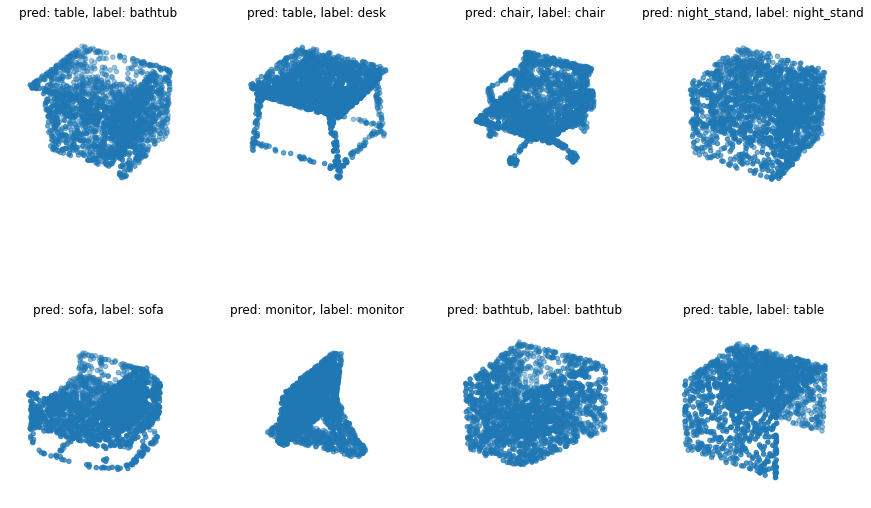

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()


In [ ]:
print(labels)

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:


plot_history(history)



In [ ]:


full_multiclass_report(model,
                       x_test,
                       y_test,
                       le.inverse_transform(np.arange(3)))



In [ ]:
print(preds
     )

NameError: ignored

In [ ]:
from tensorflow import keras
model = keras.models.load_model('path/to/location')


In [ ]:
print()

Normalized confusion matrix


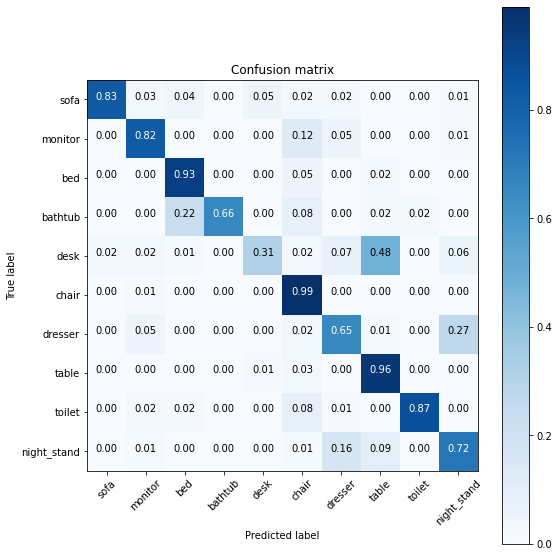

In [ ]:

     
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(correct_labels,predicted_labels);
cm
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,classes, normalize=True)

In [ ]:
print(len(test_dataset))

29


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=64,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

NotImplementedError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))
  
# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)


1/1 [==============================] - 1s 899ms/step

1/1 [==============================] - 1s 625ms/step

1/1 [==============================] - 1s 544ms/step

1/1 [==============================] - 1s 743ms/step

1/1 [==============================] - 1s 631ms/step

1/1 [==============================] - 1s 602ms/step

1/1 [==============================] - 1s 620ms/step

1/1 [==============================] - 1s 552ms/step

1/1 [==============================] - 1s 726ms/step

1/1 [==============================] - 1s 741ms/step

1/1 [==============================] - 1s 558ms/step

1/1 [==============================] - 1s 556ms/step

1/1 [==============================] - 1s 677ms/step

1/1 [==============================] - 1s 607ms/step

1/1 [==============================] - 1s 939ms/step

1/1 [==============================] - 1s 1s/step

1/1 [==============================] - 1s 745ms/step

1/1 [==============================] - 1s 733ms/step

1/1 [==========================

In [ ]:
print(concatbatches)

tf.Tensor(

[[[-1.27709016e+01  2.45288299e+01  4.28100000e-01]

  [-1.12149842e+01  9.52982802e+00 -9.07190000e+00]

  [ 1.31552951e+01 -3.11872014e+01  8.09104392e+00]

  ...

  [-1.57500000e+01  3.46428960e+01 -5.32282408e-01]

  [ 3.05979240e+00 -4.66266819e+01  8.42810000e+00]

  [ 1.19791408e+01 -5.24223998e+00 -5.07190000e+00]]



 [[ 3.89287883e+00  7.98350000e+00  1.05558719e+00]

  [-4.46767806e+00 -7.95400000e+00  1.05629365e+01]

  [-2.33329446e+00 -8.01650000e+00  8.86072166e+00]

  ...

  [ 3.64204156e+00 -3.70198940e+00  7.81250000e+00]

  [ 4.73468209e+00  7.98350000e+00  4.87585525e+00]

  [ 5.95862057e+00  3.06870141e+00 -7.25000000e+00]]



 [[-7.21624289e+00 -8.42304268e+00  3.36245000e+00]

  [ 7.57279544e-01  1.28001980e+01  3.75932486e+00]

  [-8.64532329e+00 -9.72968070e+00 -3.57635000e+00]

  ...

  [ 1.09415000e+01 -3.59880214e+00  3.76736046e-01]

  [ 1.09415000e+01  1.14711034e+01  2.62863114e+00]

  [-9.86588349e+00  9.44027625e-01  7.99250000e-01]]



 ...

In [ ]:
classes=list(CLASS_MAP.values())

In [ ]:
print(classes)

['toilet', 'monitor', 'table', 'chair', 'night_stand', 'dresser', 'desk', 'bed', 'bathtub', 'sofa']


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'